# reduced classes experiments for entropy labelling

In [81]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR

import time
import random

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

## MNIST

まずは乱数で10クラスから任意の2クラスを選ぶ;  
これは単純に二回でいいのだろうか
二回回して同じ数ならもう一度くらいでいいか...

In [73]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

img_SIZE = train_images.shape[1]*train_images.shape[2]

orig_A1 = 2000
lim_A1 = 2000

# まず選ばれる2クラスをハイパラとして与えて実験 (乱数実装はあとで)
# とりあえず0と1で試す
c1 = 0
c2 = 1

# 選ばれた2クラスだけのデータとラベルを用意
trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] == c1 or train_labels[i] == c2]
trn_labels = [label for label in train_labels if (label == c1 or label == c2)]

tst_imgs = [img for i, img in enumerate(test_imgs) if test_labels[i] == c1 or test_labels[i] == c2]
tst_labels = [label for label in test_labels if (label == c1 or label == c2)]

In [74]:
# entropy labelling for 10 classes classification
def bin_ent_label(probas):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    temp_labels = [i for i, Ipk in enumerate(info_con) if Ipk <= Hp]

    paddings = np.full(2 - len(temp_labels), np.nan)
    return np.concatenate((temp_labels, paddings), axis = 0)

In [75]:
# generate an annotator
a1_model = LR().fit(trn_imgs[:orig_A1], trn_labels[:orig_A1])
a1_proba = a1_model.predict_proba(trn_imgs[orig_A1:orig_A1 + lim_A1])

# entropy labelling
mul_labels = [bin_ent_label(probas) for i, probas in enumerate(a1_proba)]

In [76]:
# duplicating images k-1 times, for k-labels
def dup_imgs(img, labels):
    k = np.count_nonzero(np.array((~np.isnan(labels)), int))
    if k == 1:
        #print(img.shape)
        return np.array(img)
    else:
        tmp_dup = np.array([img for _ in range(k)])
        #print(tmp_dup.shape)
        return tmp_dup  
    
dupld_imgs = np.array([dup_imgs(img, mul_labels[i]) for i, img in enumerate(trn_imgs[orig_A1:orig_A1 + lim_A1])])

d_imgs = []
    
for img in dupld_imgs:
    a = img.shape
    n = a[0]
    if (n == img_SIZE):
        d_imgs.append(img)
    else:
        for _ in range(n):
            d_imgs.append(img[0])
            
d_imgs = np.array(d_imgs)

### ravelling mul_labels

In [77]:
def extract_labels(labels):
    k = np.count_nonzero(np.array((~np.isnan(labels)), int))
    return labels[:k]

mul_labels = [extract_labels(labels) for labels in mul_labels]

m_labels = []
    
for labels in mul_labels:
     [m_labels.append(l) for l in labels]

In [78]:
final_model = LR().fit(d_imgs, m_labels)
acc = accuracy_score(tst_labels, final_model.predict(tst_imgs))
print(f"{acc*100}[%]")

99.95271867612293[%]


### 画像の複製できている 2クラス問題だから複製はされないけど

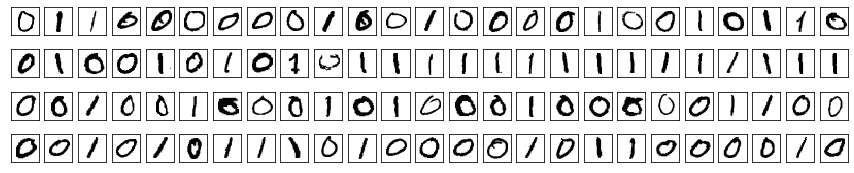

In [79]:
plt.figure(figsize = (15, 3))

for i in range(len(d_imgs[:100])):
    plt.subplot(4, 25 , i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(d_imgs[i].reshape(28, 28), cmap = plt.cm.binary)

### 同じデータと元のラベルで学習した場合

In [47]:
model = LR().fit(trn_imgs[orig_A1:orig_A1 + lim_A1], trn_labels[orig_A1:orig_A1 + lim_A1])
acc = accuracy_score(tst_labels, model.predict(tst_imgs))
print(f"{acc*100}[%]")

99.95271867612293[%]


## CIFAR 10

In [50]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

# まず選ばれる2クラスをハイパラとして与えて実験 (乱数実装はあとで)
# とりあえず0と1で試す
c1 = 0
c2 = 1

# 選ばれた2クラスのデータだけ抽出
trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] == c1 or train_labels[i] == c2]
trn_labels = [label for label in train_labels if (label == c1 or label == c2)]

tst_imgs = [img for i, img in enumerate(test_imgs) if test_labels[i] == c1 or test_labels[i] == c2]
tst_labels = [label for label in test_labels if (label == c1 or label == c2)]

images shape transformation; (50000, 32, 32, 3) -> (50000, 3072)



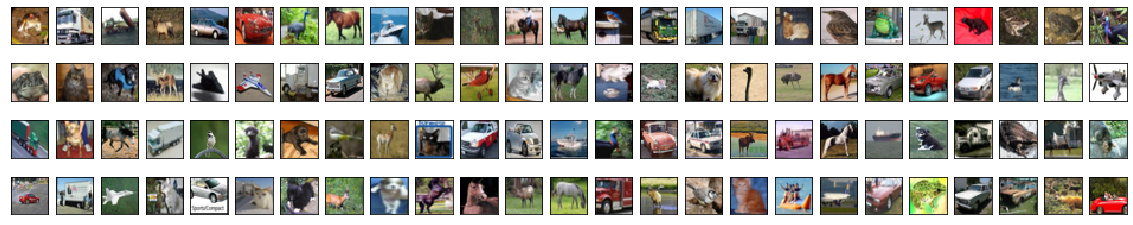

In [11]:
# rgb画像なので，3つ組1つが各pixelの色(rgb値)を決める
# データの一つ一つは32x32x3の画像 -> ravelすることで32*32*3がフラットに
# https://keras.io/datasets/

print(f"images shape transformation; {train_images.shape} -> {train_imgs.shape}\n")

plt.figure(figsize=(20, 4))
for i, img in enumerate(train_images[:100]):
    plt.subplot(4, 25, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(img)

In [52]:
orig_A2 = 2000
lim_A2 = 2000

# generate an annotator
a2_model = LR().fit(trn_imgs[:orig_A2], trn_labels[:orig_A2])
a2_proba = a2_model.predict_proba(trn_imgs[orig_A2:orig_A2 + lim_A2])

# entropy labelling
mul_labels = [bin_ent_label(probas) for i, probas in enumerate(a2_proba)]

In [53]:
# duplicating images k-1 times, for k-labels
def dup_imgs(img, labels):
    k = np.count_nonzero(np.array((~np.isnan(labels)), int))
    if k == 1:
        #print(img.shape)
        return np.array(img)
    else:
        tmp_dup = np.array([img for _ in range(k)])
        #print(tmp_dup.shape)
        return tmp_dup  
    
dupld_imgs = np.array([dup_imgs(img, mul_labels[i]) for i, img in enumerate(trn_imgs[orig_A2:orig_A2 + lim_A2])])

d_imgs = []
    
for img in dupld_imgs:
    a = img.shape
    n = a[0]
    if (n == img_SIZE):
        d_imgs.append(img)
    else:
        for _ in range(n):
            d_imgs.append(img[0])
            
d_imgs = np.array(d_imgs)

### ravelling mul_labels

In [54]:
def extract_labels(labels):
    k = np.count_nonzero(np.array((~np.isnan(labels)), int))
    return labels[:k]

mul_labels = [extract_labels(labels) for labels in mul_labels]

m_labels = []
    
for labels in mul_labels:
     [m_labels.append(l) for l in labels]

In [55]:
final_model = LR().fit(d_imgs, m_labels)
acc = accuracy_score(tst_labels, final_model.predict(tst_imgs))
print(f"{acc*100}[%]")

79.05[%]


### 画像の複製できている

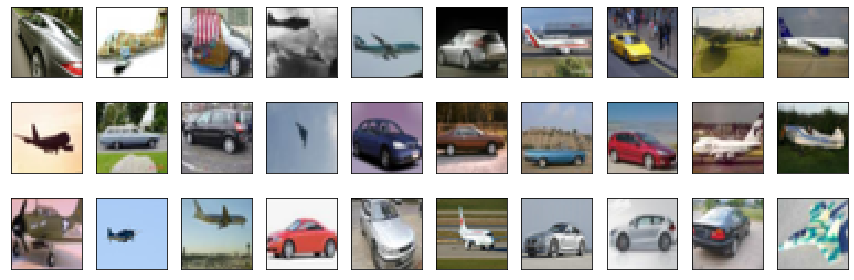

In [56]:
plt.figure(figsize = (15, 5))

for i, img in enumerate(d_imgs[:30]):
    plt.subplot(3, 10 , i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(img.reshape(32, 32, 3))

### 同じデータと元のラベルで学習した場合

In [57]:
model = LR().fit(trn_imgs[orig_A2:orig_A2 + lim_A2], trn_labels[orig_A2:orig_A2 + lim_A2])
acc = accuracy_score(tst_labels, model.predict(tst_imgs))
print(f"{acc*100}[%]")

79.45[%]


## CIFAR100

In [60]:
from keras.datasets import cifar100

(train_images, train_labels), (test_images, test_labels) = cifar100.load_data(label_mode='fine')

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

# まず選ばれる2クラスをハイパラとして与えて実験 (乱数実装はあとで)
# とりあえず0と1で試す
c1 = 0
c2 = 1

# 選ばれた2クラスのデータだけ抽出
trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] == c1 or train_labels[i] == c2]
trn_labels = [label for label in train_labels if (label == c1 or label == c2)]

tst_imgs = [img for i, img in enumerate(test_imgs) if test_labels[i] == c1 or test_labels[i] == c2]
tst_labels = [label for label in test_labels if (label == c1 or label == c2)]

In [61]:
# entropy labelling for 10 classes classification
def bin_ent_label100(probas):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    temp_labels = [i for i, Ipk in enumerate(info_con) if Ipk <= Hp]

    paddings = np.full(100 - len(temp_labels), np.nan)
    return np.concatenate((temp_labels, paddings), axis = 0)

In [64]:
orig_A3 = 200
lim_A3 = 200

# generate an annotator
a3_model = LR().fit(trn_imgs[:orig_A3], trn_labels[:orig_A3])
a3_proba = a3_model.predict_proba(trn_imgs[orig_A3:orig_A3 + lim_A3])

# entropy labelling
mul_labels = [bin_ent_label100(probas) for i, probas in enumerate(a3_proba)]

In [65]:
# duplicating images k-1 times, for k-labels
def dup_imgs(img, labels):
    k = np.count_nonzero(np.array((~np.isnan(labels)), int))
    if k == 1:
        return np.array(img)
    else:
        tmp_dup = np.array([img for _ in range(k)])
        return tmp_dup  
    
dupld_imgs = np.array([dup_imgs(img, mul_labels[i]) for i, img in enumerate(train_imgs[orig_A3:orig_A3 + lim_A3])])

d_imgs = []
    
for img in dupld_imgs:
    a = img.shape
    n = a[0]
    if (n == img_SIZE):
        d_imgs.append(img)
    else:
        for _ in range(n):
            d_imgs.append(img[0])
            
d_imgs = np.array(d_imgs)

### ravelling mul_labels

In [66]:
def extract_labels(labels):
    k = np.count_nonzero(np.array((~np.isnan(labels)), int))
    return labels[:k]

mul_labels = [extract_labels(labels) for labels in mul_labels]

m_labels = []
    
for labels in mul_labels:
     [m_labels.append(l) for l in labels]

### max_iterを200に増やして (default 100) 学習

In [67]:
final_model = LR(max_iter = 200).fit(d_imgs, m_labels)
acc = accuracy_score(tst_labels, final_model.predict(tst_imgs))
print(f"{acc*100}[%]")

51.5[%]


### 画像の複製できている

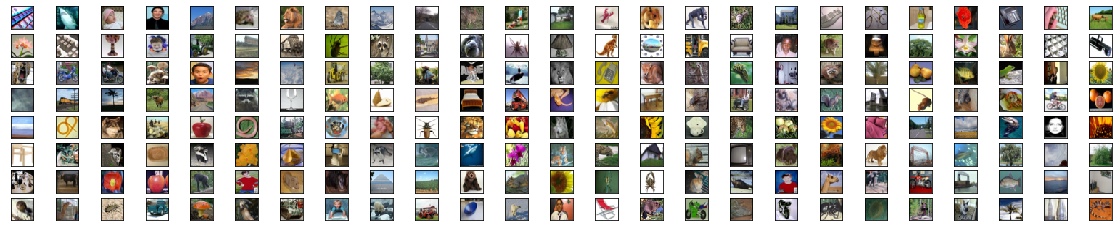

In [68]:
plt.figure(figsize = (20, 20))

for i, img in enumerate(d_imgs[:1000]):
    plt.subplot(40, 25 , i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(img.reshape(32, 32, 3))

### 同じデータと元のラベルで学習した場合

In [69]:
model = LR().fit(trn_imgs[orig_A3:orig_A3 + lim_A3], trn_labels[orig_A3:orig_A3 + lim_A3])
acc = accuracy_score(tst_labels, model.predict(tst_imgs))
print(f"{acc*100}[%]")

80.0[%]
